In [5]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering

df_m = pd.read_parquet("../artifacts/reduceddata.parquet", engine="pyarrow")


In [6]:
df_m = df_m.dropna()


In [7]:
df_m.head()


,fit,user_id,item_id,weight_lbs,rating,rented_for,body_type,category,size,age,review_date,bust_size_num,bust_size_letter,height_in,review_month,review_day_of_month,review_year,recommend
0,fit,420272,2260466,137.0,10.0,vacation,hourglass,romper,14,28.0,2016-04-20,34.0,d,68.0,4,20,2016,1
4,fit,151944,616682,145.0,10.0,wedding,athletic,gown,12,27.0,2016-09-26,34.0,b,69.0,9,26,2016,1
6,fit,336066,568429,112.0,10.0,everyday,hourglass,dress,4,27.0,2017-12-07,34.0,c,63.0,12,7,2017,1
9,fit,154309,1729232,114.0,10.0,formal affair,petite,gown,1,33.0,2016-10-17,32.0,b,63.0,10,17,2016,1
12,fit,87660,1295171,120.0,10.0,party,straight & narrow,sheath,8,26.0,2016-07-28,36.0,a,66.0,7,28,2016,1


In [8]:
sorted(list(df_m["bust_size_letter"].unique()))


['a', 'aa', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j']

In [9]:
df_m["bust_size_letter"] = pd.Categorical(df_m["bust_size_letter"]).codes


In [9]:
numeric_features = [
    "user_id",
    "weight_lbs",
    "age",
    "size",
    "bust_size_letter",
    "height_in",
]
df_clu = df_m[numeric_features]
# imp_median = IterativeImputer(random_state=1234)
# imp_median.fit(df_clu)
# df_clu= pd.DataFrame(imp_median.transform(df_clu),columns=df_clu.columns)
# df_clu.bust_size_letter = df_clu.bust_size_letter.astype('int')


In [10]:
users = (
    df_clu[["user_id", "age", "size", "bust_size_letter", "height_in", "weight_lbs"]]
    .groupby("user_id")
    .median()
    .reset_index()
)


In [11]:
users_freq = df_m.groupby(["user_id"]).agg({"item_id": "count"}).reset_index()
user_1 = list(users_freq[users_freq["item_id"] > 1]["user_id"])
df_m_3 = df_m[df_m["user_id"].isin(user_1)]
df_users = users[users["user_id"].isin(user_1)].reset_index(drop=True)
df_users_no_id = df_users.iloc[:, 1:]


### Dendrogram

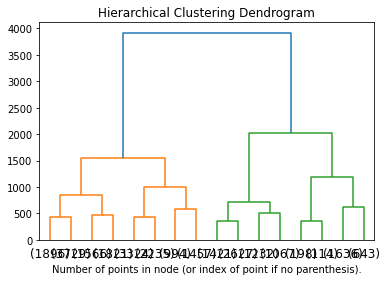

In [14]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)


# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)

model = model.fit(df_users_no_id)
plt.title("Hierarchical Clustering Dendrogram")
# plot the top three levels of the dendrogram
plot_dendrogram(model, truncate_mode="level", p=3)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()


### K_Mean

In [15]:
from sklearn.cluster import KMeans


def ClusterIndicesNumpy(clustNum, labels_array):  # numpy
    return np.where(labels_array == clustNum)[0]


kmeans_n = KMeans(n_clusters=4, random_state=1234).fit(df_users_no_id)
kmeans_n.labels_
kmeans_n.cluster_centers_
index_1 = ClusterIndicesNumpy(1, kmeans_n.labels_)
index_2 = ClusterIndicesNumpy(2, kmeans_n.labels_)
index_3 = ClusterIndicesNumpy(3, kmeans_n.labels_)
index_0 = ClusterIndicesNumpy(0, kmeans_n.labels_)
clusters = [index_0, index_1, index_2, index_3]
mean_age = []
mean_size = []
mean_bust_size = []
mean_heigt = []
mean_weight = []
means = [mean_age, mean_size, mean_bust_size, mean_heigt, mean_weight]
values = ["age", "size", "bust_size_letter", "height_in", "weight_lbs"]
for i in range(5):
    for j in range(4):
        means[i].append(df_users_no_id.loc[clusters[j]].describe()[values[i]][1])


### Dataset per Clauster

In [21]:
df_C0 = df_m.iloc[index_0]
df_C1 = df_m.iloc[index_1]
df_C2 = df_m.iloc[index_2]
df_C3 = df_m.iloc[index_3]


In [11]:
df_C0.to_csv("../artifacts/Cluster_0.csv", index=False)
df_C1.to_csv("../artifacts/Cluster_1.csv", index=False)
df_C2.to_csv("../artifacts/Cluster_2.csv", index=False)
df_C3.to_csv("../artifacts/Cluster_3.csv", index=False)


NameError: name 'df_C0' is not defined

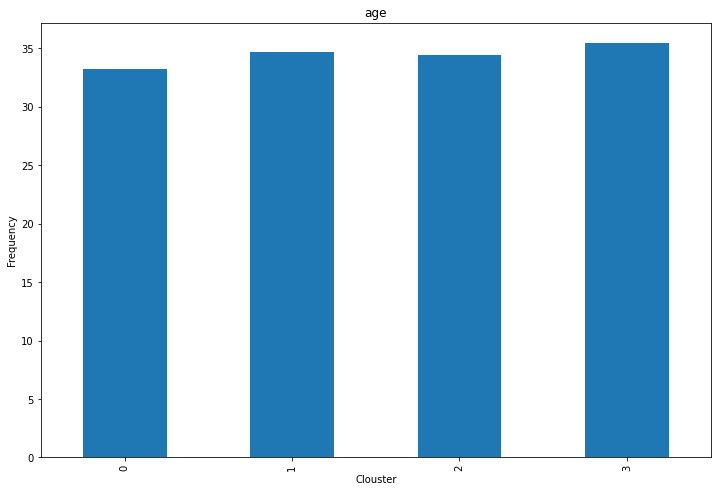

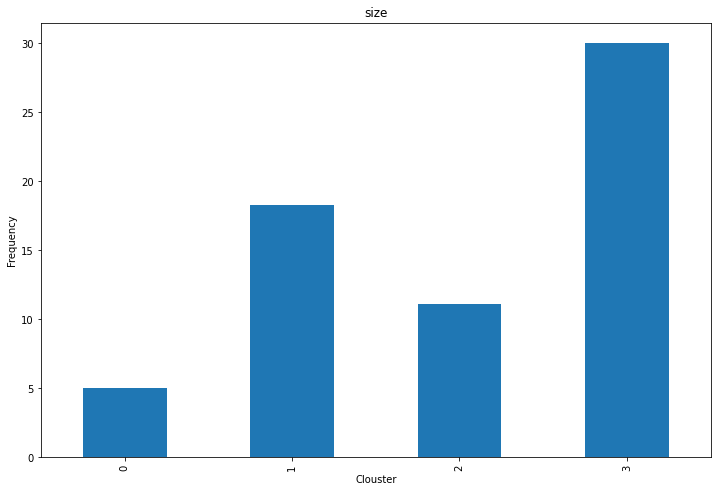

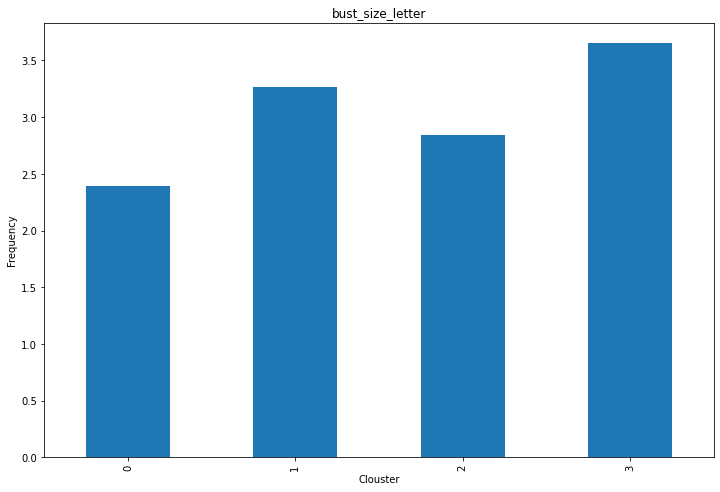

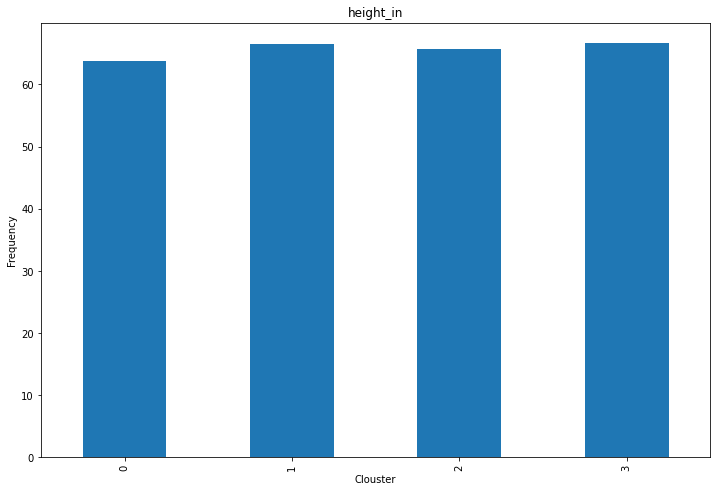

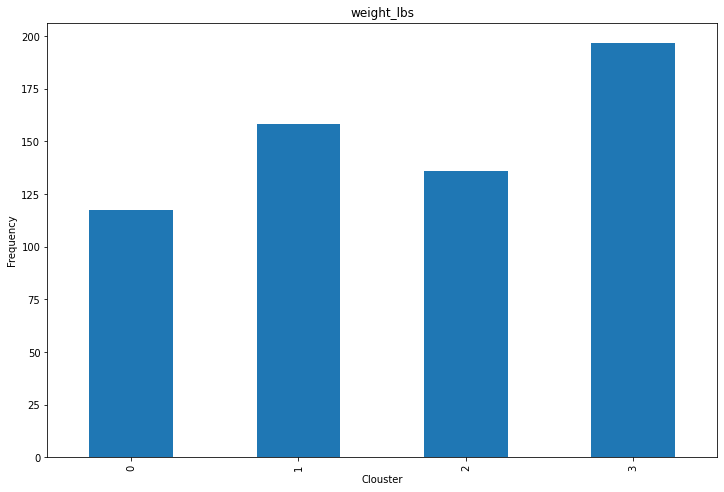

In [16]:
x_labels = np.arange(len(means[0]))

for i in range(len(means)):
    # plt.bar(np.arange(len(means[i])), means[i])
    # plt.set_label(values[i])
    # plt.legend

    plt.figure(figsize=(12, 8))
    freq_series = pd.Series(means[i])
    ax = freq_series.plot(kind="bar")
    ax.set_title(values[i])
    ax.set_xlabel("Cluster")
    ax.set_ylabel("Frequency")
    ax.set_xticklabels(x_labels)
plt.show()
